# Predicting Energy Demand in Europe Using Air Quality Data

The data for this project was obtained from the UCI Machine Learning Repository, which is a collection of databases, domain theories, and data generators that are used for research and development in the field of machine learning. The dataset used in this project, named "Energy Efficiency Data Set" contains information about the heating load and cooling load requirements of buildings, as well as their design parameters such as relative compactness, surface area, wall area, roof area, overall height, orientation, glazing area and glazing area distribution. The data was used to predict energy demand for a specific region or building.
The variables are:

| Variable | Description |
| --- | --- |
| X1 | Relative Compactness |
| X2 | Surface Area |
| X3 | Wall Area |
| X4 | Roof Area |
| X5 | Overall Height |
| X6 | Orientation |
| X7 | Glazing Area |
| X8 | Glazing Area Distribution |
| y1 | Heating Load |
| y2 | Cooling

*The variables to predict are:*  
`y1` represents the heating load required by the building, measured in watts per square meter.  
`y2` represents the cooling load required by the building, measured in watts per square meter.  

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as scs
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import QuantileTransformer, RobustScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [65]:
def adjusted_r2(y_true, y_pred, n, k): 
    r2 = r2_score(y_true, y_pred) 
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1) 
    return adj_r2

Read and rename the dataset in order to understand the information I am working on.

In [66]:
df = pd.read_excel('data/ENB2012_data.xlsx')
df = df.rename(columns={'X1':'relative_compactness', 
                        'X2':'surface_area', 
                        'X3':'wall_area', 
                        'X4':'roof_area', 
                        'X5':'overall_height', 
                        'X6':'orientation', 
                        'X7':'glazing_area', 
                        'X8':'glazing_area_distribution', 
                        'Y1':'heating_load', 
                        'Y2':'cooling_load'})
df.head()

,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   relative_compactness       768 non-null    float64
 1   surface_area               768 non-null    float64
 2   wall_area                  768 non-null    float64
 3   roof_area                  768 non-null    float64
 4   overall_height             768 non-null    float64
 5   orientation                768 non-null    int64  
 6   glazing_area               768 non-null    float64
 7   glazing_area_distribution  768 non-null    int64  
 8   heating_load               768 non-null    float64
 9   cooling_load               768 non-null    float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB


There aren't columns with missing values.

In [68]:
df.describe()

,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307195,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090204,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


I will try to understand the ranges and the type of numeric values each variable contains. 

In [69]:
for col in df.columns[:-2]:
    print(col, ':', len(df[col].unique()))
    print(col, ':', df[col].unique())
    print()

relative_compactness : 12
relative_compactness : [0.98 0.9  0.86 0.82 0.79 0.76 0.74 0.71 0.69 0.66 0.64 0.62]

surface_area : 12
surface_area : [514.5 563.5 588.  612.5 637.  661.5 686.  710.5 735.  759.5 784.  808.5]

wall_area : 7
wall_area : [294.  318.5 343.  416.5 245.  269.5 367.5]

roof_area : 4
roof_area : [110.25 122.5  147.   220.5 ]

overall_height : 2
overall_height : [7.  3.5]

orientation : 4
orientation : [2 3 4 5]

glazing_area : 4
glazing_area : [0.   0.1  0.25 0.4 ]

glazing_area_distribution : 6
glazing_area_distribution : [0 1 2 3 4 5]



There are 5 float variables and 2 integer variables. Even though overall height is a float variables there are only 2 possible values so in that case a Bar plot is showed. 

In [70]:
continuous_vars = ["relative_compactness", "surface_area", "wall_area","roof_area", "overall_height","glazing_area"  ]

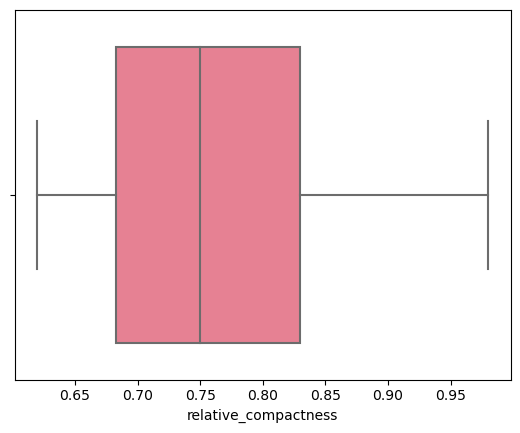

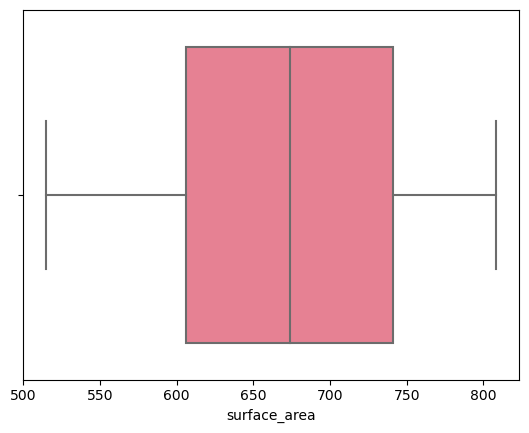

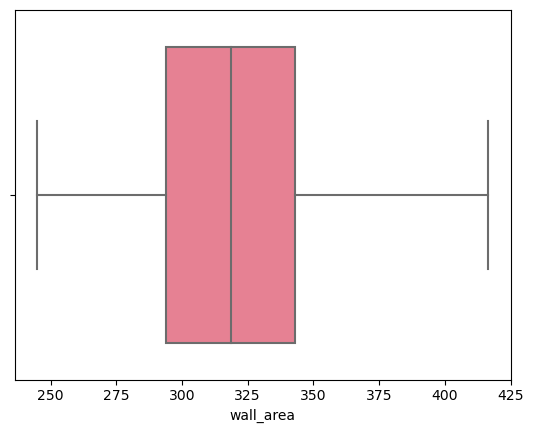

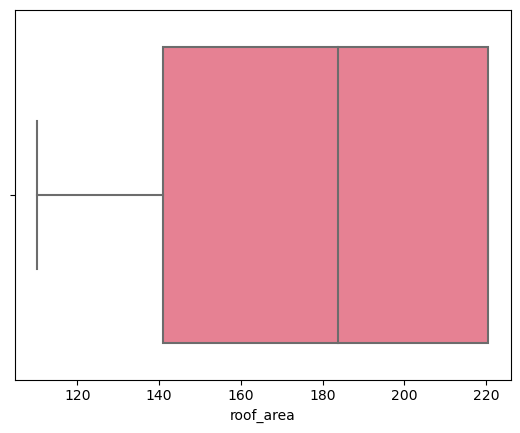

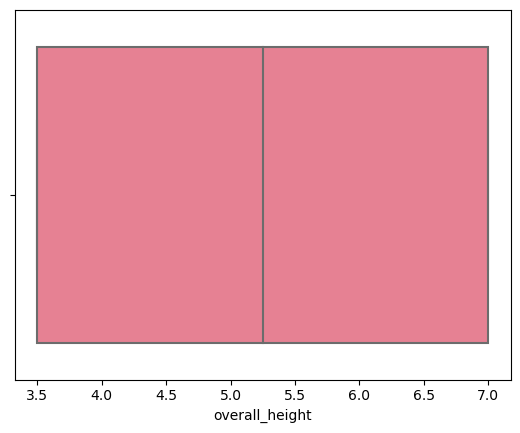

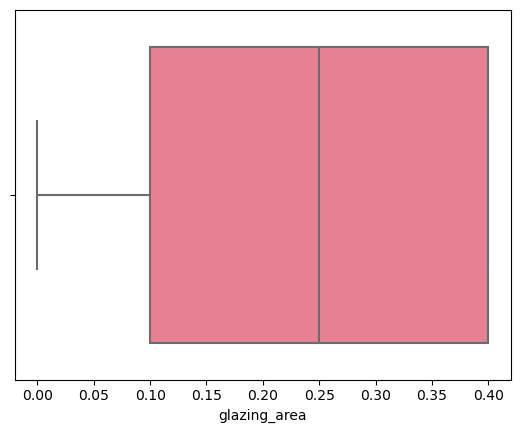

In [71]:

for col in continuous_vars:
    plt.figure()
    sns.boxplot(data=df, x=col, color = "blue")    

For being able to perform a linear regression there are some requirements our dataset must fulfill in order to apply the model:
- *Linearity:* The relationship between the independent and dependent variables should be linear. This means that a change in the independent variable should result in a proportional change in the dependent variable.

- *Independence:* The observations used in the model should be independent of each other. This means that the value of the dependent variable for one observation should not be affected by the value of the dependent variable for any other observation.

- *Homoscedasticity:* The variance of the errors should be constant across all levels of the independent variables. This means that the spread of the residuals (the difference between the observed and predicted values) should be similar for all values of the independent variables.

- *Normality:* The errors should be normally distributed. This means that the distribution of the residuals should be bell-shaped and symmetric.

 - *No multicollinearity:* There should not be a high degree of correlation among the independent variables. This can lead to unstable estimates of the coefficients and make it difficult to interpret the results.

The correlation matrix shows the correlation coefficients between multiple variables. It is important because it helps to identify patterns and relationships between variables. Here I use it to understand better the data I am working on and to identify potential problems with a dataset, such as multicollinearity, which can affect the interpretation of statistical models. 

In [72]:
corr_mat = df.corr()
corr_mat.style.background_gradient(cmap='coolwarm' ).set_precision(2)

C:\Users\marti\AppData\Local\Temp\ipykernel_10540\2345108109.py:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr_mat.style.background_gradient(cmap='coolwarm' ).set_precision(2)


,relative_compactness,surface_area,wall_area,roof_area,overall_height,orientation,glazing_area,glazing_area_distribution,heating_load,cooling_load
relative_compactness,1.00,-0.99,-0.20,-0.87,0.83,0.00,-0.00,-0.00,0.62,0.63
surface_area,-0.99,1.00,0.20,0.88,-0.86,-0.00,0.00,0.00,-0.66,-0.67
wall_area,-0.20,0.20,1.00,-0.29,0.28,-0.00,-0.00,0.00,0.46,0.43
roof_area,-0.87,0.88,-0.29,1.00,-0.97,-0.00,-0.00,-0.00,-0.86,-0.86
overall_height,0.83,-0.86,0.28,-0.97,1.00,0.00,0.00,-0.00,0.89,0.90
orientation,0.00,-0.00,-0.00,-0.00,0.00,1.00,-0.00,-0.00,-0.00,0.01
glazing_area,-0.00,0.00,-0.00,-0.00,0.00,-0.00,1.00,0.21,0.27,0.21
glazing_area_distribution,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.21,1.00,0.09,0.05
heating_load,0.62,-0.66,0.46,-0.86,0.89,-0.00,0.27,0.09,1.00,0.98
cooling_load,0.63,-0.67,0.43,-0.86,0.90,0.01,0.21,0.05,0.98,1.00



The variables are correlated when the Pearson's Coefficients are near 1. So there are stong relationships between,

-Relative Compactness and Surface Area  
-Relative Compactness and Roof Area  
-Relative Compactness and Overall Height  
-Surface Area and Roof Area  
-Surface Area and Overall Height  
-Roof Area and Overall Height  

There is another option to find collinearity among variables that is the VIF. It quantifies the degree in which variable's variance increases due to the presence of other correlated variable in the model. A VIF score is calculated for each independent variable in the model, and a high score indicates a high degree of collinearity.


In [73]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=["heating_load", "cooling_load"])
y = df['heating_load']

In [74]:
X_vif = X[['relative_compactness','surface_area','overall_height','roof_area']]

vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_info['Column'] = X_vif.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
1,321.043895,surface_area
3,289.336509,roof_area
0,166.405334,relative_compactness
2,133.952720,overall_height


We can try removing surface area.

In [75]:
X_vif = X[['relative_compactness','overall_height','roof_area']]

vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_info['Column'] = X_vif.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
0,124.573223,relative_compactness
1,57.968643,overall_height
2,20.749703,roof_area


Now removing relative compactness.

In [76]:
X_vif = X[['overall_height','roof_area']]

vif_info = pd.DataFrame()
vif_info['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
vif_info['Column'] = X_vif.columns
vif_info.sort_values('VIF', ascending=False)

,VIF,Column
0,3.455736,overall_height
1,3.455736,roof_area


If the values are between 1 and 5 there is a moderated correlation and acceptable.

In [77]:
X = X.drop(columns = ['relative_compactness','surface_area'])

Now the next step is to check the skewness in order to understand the normality of the data. Skewness is  a measure of the asymmetry of a distribution.

In [78]:
X.shape

(768, 6)

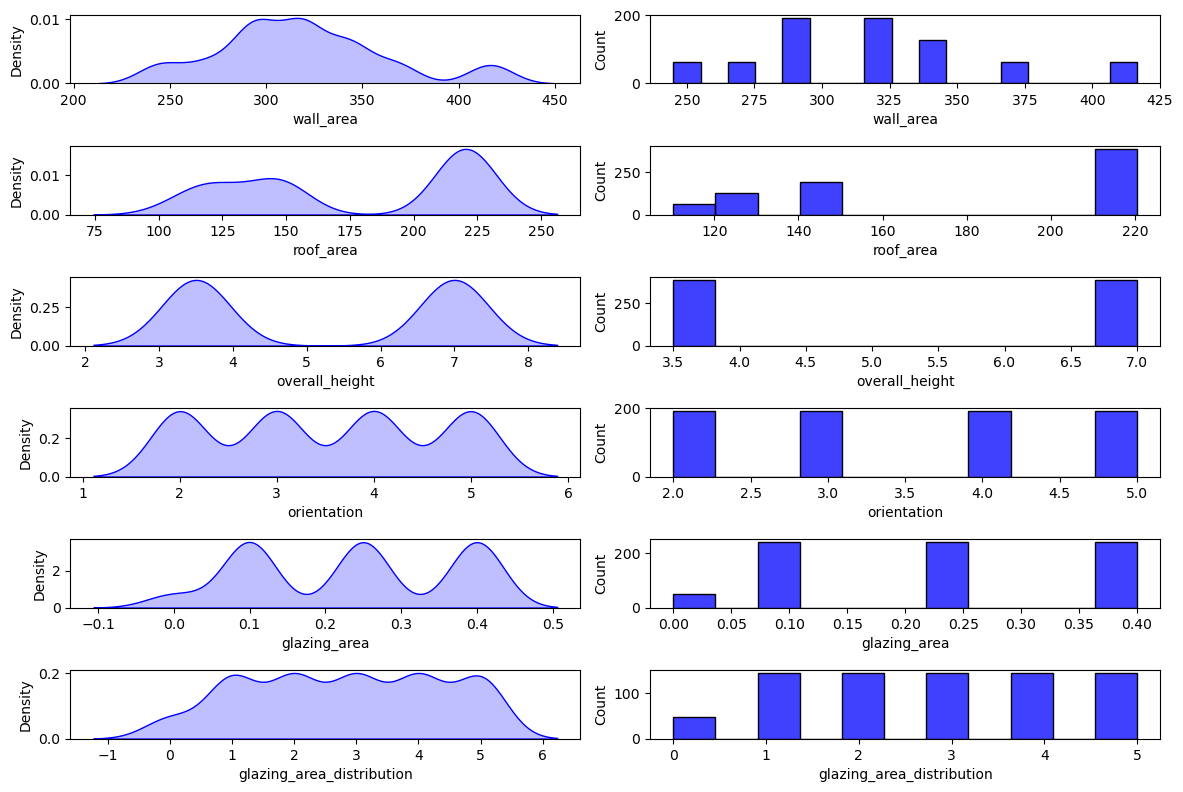

In [79]:
fig, ax = plt.subplots(6, 2, figsize=(12,8))

for i in range(6):
    sns.kdeplot(ax=ax[i, 0], x=X.columns[i], data=X, fill = True, color = 'blue')
    sns.histplot(ax=ax[i, 1], x=X.columns[i], data=X, color = 'blue')
fig.tight_layout(pad=1)
plt.show()

It is clear that wall area and roof area are not symetric.

In [80]:
print(X['wall_area'].skew())
print(X['roof_area'].skew())

0.5334174896788307
-0.1627639978112447


First to solve it I will try with a Log transform.

In [81]:
wall_log = np.log(X['wall_area'])
print(wall_log.skew())


0.16334417449121733


It solves the problem, since if the value of skewness is between -0.5 and 0.5 it is fairly symmetrical. I will show another option that is the QuantileTransformer:

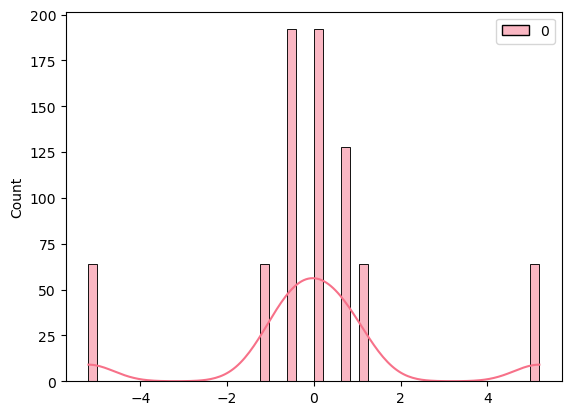

In [82]:
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal')
wallAreaTransformed = qt.fit_transform(np.array(X['wall_area']).reshape(-1, 1))
sns.histplot(wallAreaTransformed, bins = 50, kde = True)
plt.show()

In [83]:
scs.skew(wallAreaTransformed)

array([-0.00161873])

In [84]:
X['wall_area_transformed'] = wallAreaTransformed
X.drop('wall_area', axis=1, inplace=True)

# Modeling!  

Some options to validate this kind of models (regressions) are:
- MSE: Is the average of the squares of the error.
- Adjusted R-squared: Is a measure of the amount of variance in the target variable that is explained by the model, taking into account the number of predictor variables.

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

First I will try with a DecisionTreeRegressor. This is simple to understand and to build. It is constructed by splitting the data into different branches based on the predictor variables. The predictions are then made by traversing the tree and making a prediction based on the values of the predictor variables. Watching the shape of the tree lets you know the most important variables in order to split the data and to predict.

In [86]:
DTReg = DecisionTreeRegressor(random_state=17)
DTReg.fit(X_train, y_train)
y_pred = DTReg.predict(X_test)
r2 = adjusted_r2(y_pred, y_test, X_train.shape[0], X_train.shape[1])
print(f'adjusted R2 Score: {r2:.5f}')

mse = mean_squared_error(y_pred, y_test)
print(f'MSE: {mse:.5f}')

adjusted R2 Score: 0.99731
MSE: 0.26256


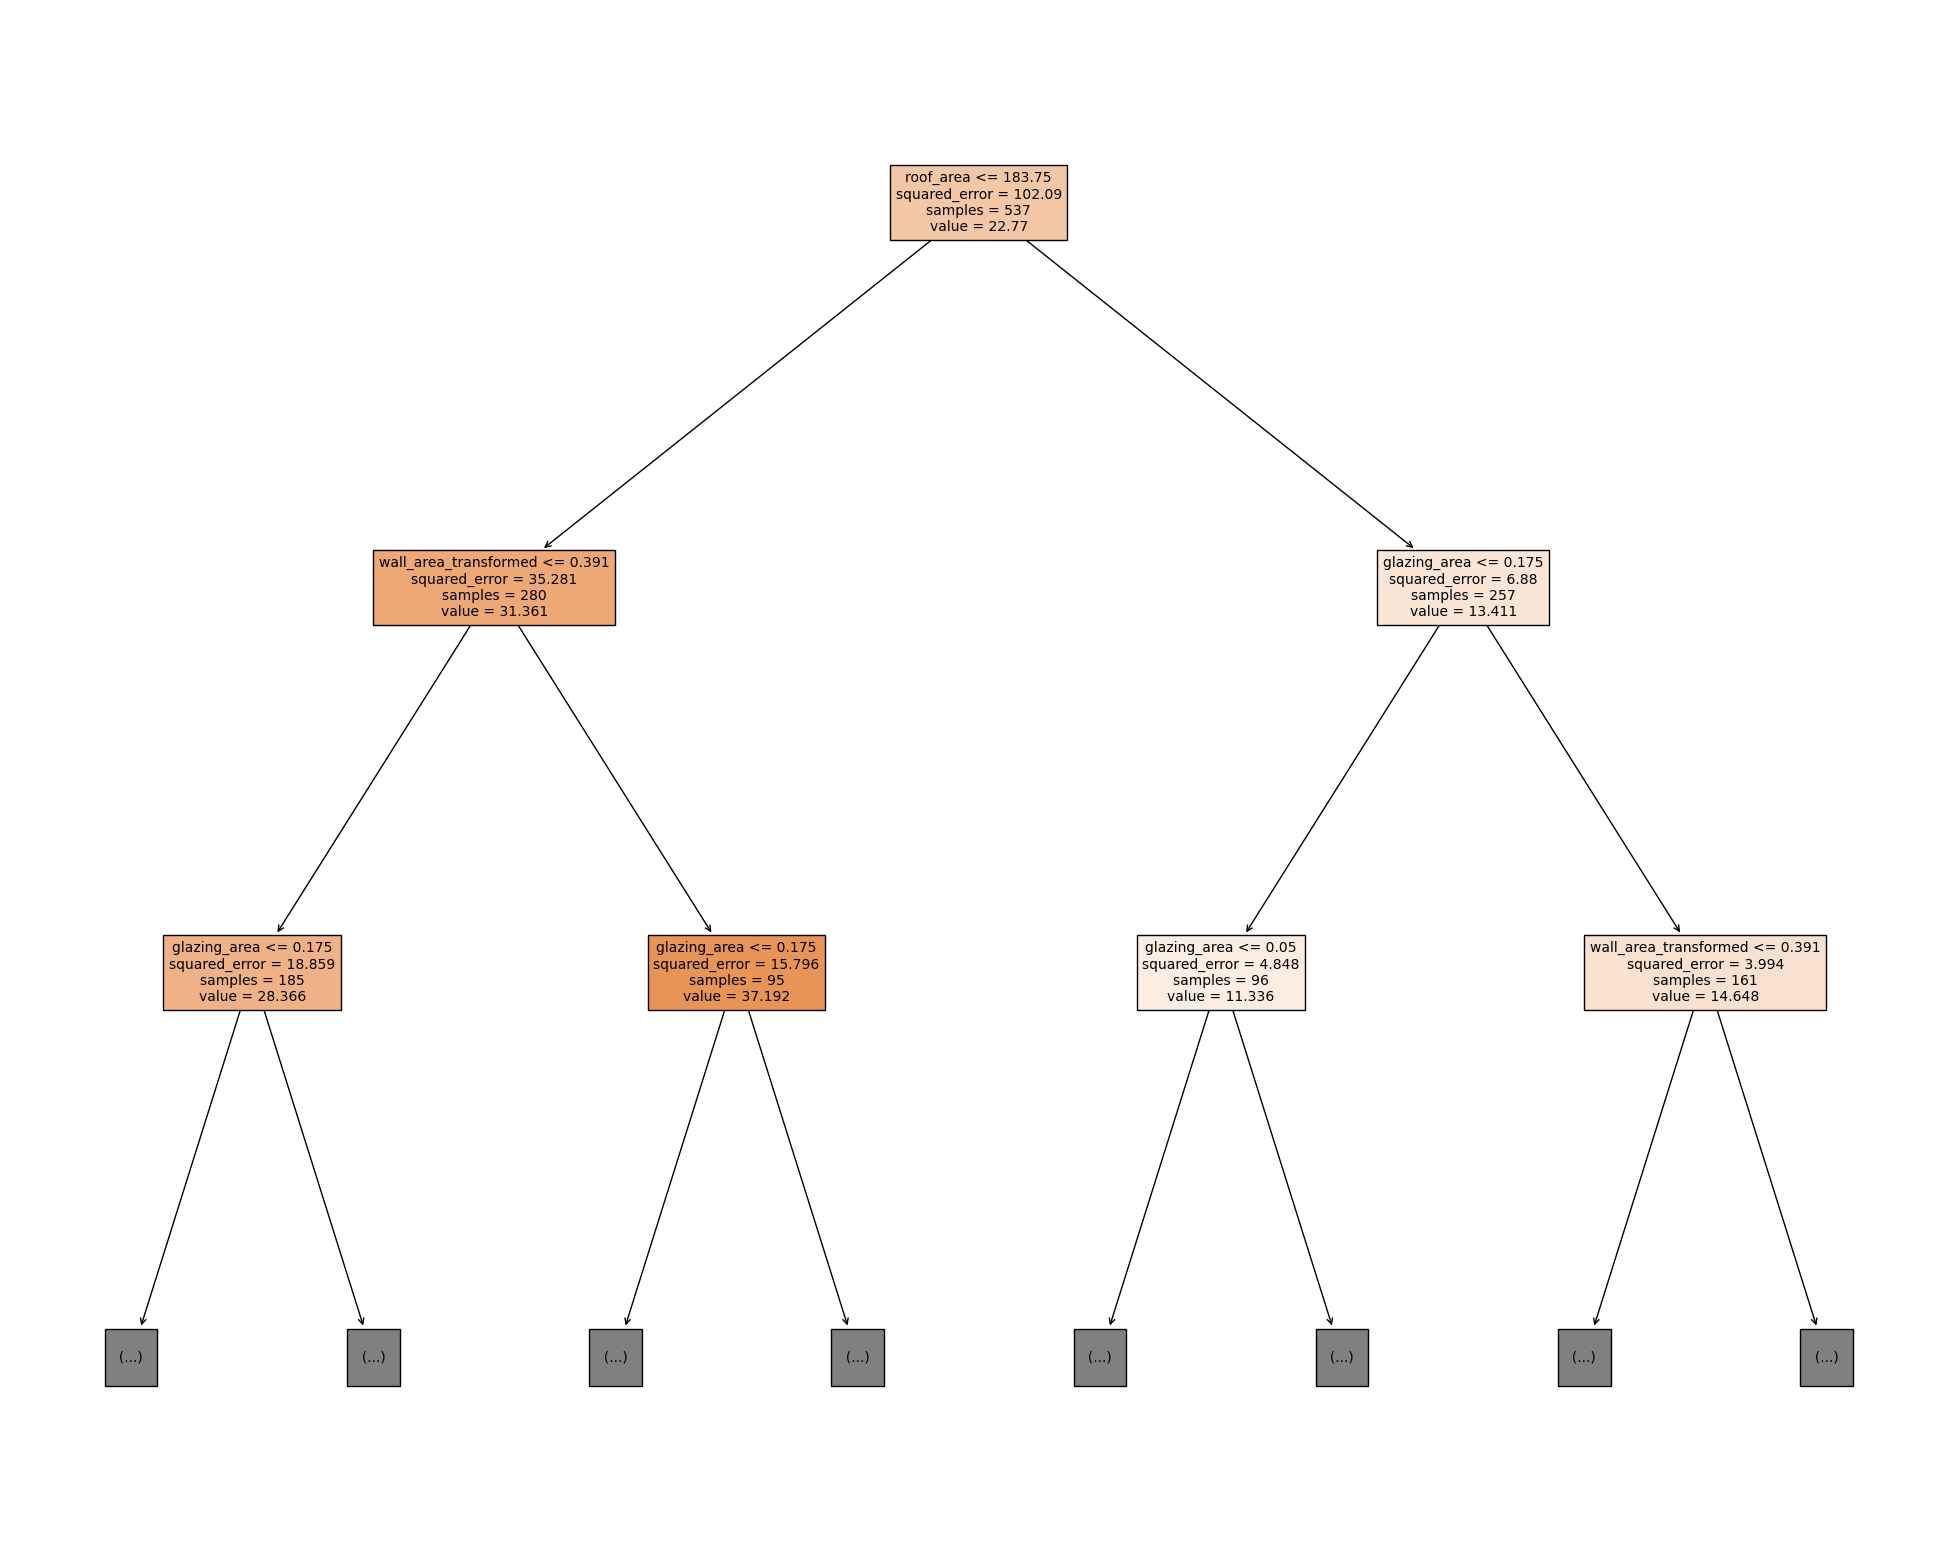

In [87]:
from sklearn import tree

fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(DTReg, 
                   feature_names= X_train.columns,  
                   class_names= "heating_load",
                   filled=True,
                   max_depth= 2
                   )


After trying a Decision Tree Regressor, I will try a Random Forest Regressor. Random Forest Regressor is an ensemble learning method that uses multiple Decision Trees to make predictions. By combining multiple Decision Trees, the model is able to capture more complex relationships between the predictor variables and the target variable. Additionally, Random Forest Regressor is less prone to overfitting than Decision Tree Regressor, which makes it better suited for making accurate predictions.

In [88]:
RFReg = RandomForestRegressor(n_estimators=100, random_state=42)
RFReg.fit(X_train, y_train)
y_pred_rf = RFReg.predict(X_test)
r2 = adjusted_r2(y_pred_rf, y_test, X_train.shape[0], X_train.shape[1])
print(f'adjusted R2 Score: {r2:.5f}')

mse = mean_squared_error(y_pred_rf, y_test)
print(f'MSE: {mse:.5f}')

adjusted R2 Score: 0.99801
MSE: 0.19381


Both are good but the RandomForest has a lower MSE value so is better. 
Now I will use a Robust Scaler and try a Linear Regression. Linear Regression is a linear model that is used to predict a continuous target variable based on one or more predictor variables. By using a Robust Scaler, that uses the median and the IQR to scale data. This will allow me to make more accurate predictions using the Linear Regression model.


In [89]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [90]:
linReg = LinearRegression()
linReg.fit(X_train_scaled, y_train)
y_pred = linReg.predict(X_test_scaled)
r2 = adjusted_r2(y_pred, y_test, X_train.shape[0], X_train.shape[1])
print(f'adjusted R2 Score: {r2:.5f}')

mse = mean_squared_error(y_pred, y_test)
print(f'MSE: {mse:.5f}')

adjusted R2 Score: 0.89362
MSE: 9.32881


The results are worse than the tree based models. I will try with a polynomial transformation to add more complexity to the model. By generating polynomial features, the model can capture more complex relationships between the predictor variables and the target variable, which can lead to more accurate predictions.

In [91]:
poly = PolynomialFeatures(3)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

In [92]:
linReg.fit(X_train_poly, y_train)
y_pred = linReg.predict(X_test_poly)
r2 = adjusted_r2(y_pred, y_test, X_train.shape[0], X_train.shape[1])
print(f'adjusted R2 Score: {r2:.5f}')

mse = mean_squared_error(y_pred, y_test)
print(f'MSE: {mse:.5f}')

adjusted R2 Score: 0.99197
MSE: 0.77888


It really improves the prediction.
Finally I will try a L2 Regression. It is a Linear Regression with regularization in order to help the model avoid overfitting. 

In [93]:
ridgeReg = Ridge(alpha = 0.001)
ridgeReg.fit(X_train_poly, y_train)
y_pred = ridgeReg.predict(X_test_poly)
r2 = adjusted_r2(y_pred, y_test, X_train.shape[0], X_train.shape[1])
print(f'adjusted R2 Score: {r2:.5f}')

mse = mean_squared_error(y_pred, y_test)
print(f'MSE: {mse:.5f}')

adjusted R2 Score: 0.99126
MSE: 0.84374


c:\Users\marti\miniconda3\envs\portfolio\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.03163e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


There is a summary of the results:

| Model | Adjusted R2 | MSE
| --- | --- | ---
| DecisionTreeRegressor |  0.99731 | 0.26256
| RandomForestRegressor |  0.99801 | 0.19381
| LinearRegression + RobustScaler | 0.89362 | 9.32881
| LinearRegression + Polynomial Features | 0.99197 | 0.77888
| L2 Regression | 0.99126 | 0.84374


Even though most models are really good we choose RandomForest that is the best. Now I plot an histogram of the differences between real and predicted values. The shape loos good as most of the differences are around 0.

<AxesSubplot: xlabel='heating_load', ylabel='Count'>

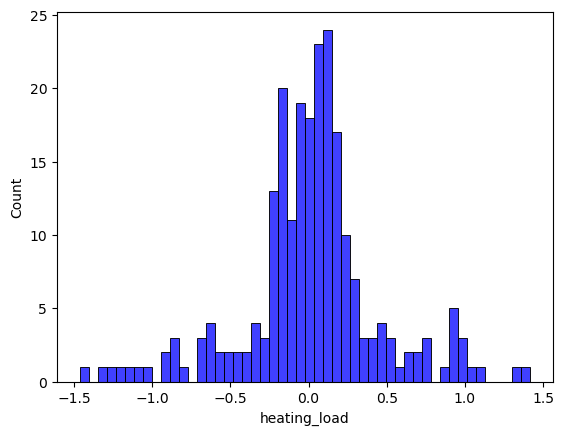

In [94]:
sns.set_palette("husl")
sns.histplot(y_test-y_pred_rf,bins=50, color = "blue")

# Summary
It was a clean dataset because it had no missing value or outliers, while there was multi-collinearity problem and skewed feature. Multi-collinearity problem was solved using the Pearson Correlation and VIFs with the decision to drop Relative Compactness and Surface Area features. Also Wall Area was skewed so we tried with a log transform and with transforming it using Quantile Transformer that is robust in nature.

Most models had 97-99% adjusted R2 scores which are great results, always validating that it isn't overfitted which is not because we validated with test data.